# Grid-Based Stop Detection

The stop detection algorithms implemented in `nomad` support different combinations of input formats that are common in commercial datasets, detecting default names when possible
- timestamps in `datetime64[ns, tz]` or as unix seconds in integers
- geographic coordinates (`lon`, `lat`) which use the Haversine distance or projected coordinates (`x`, `y`) using meters and euclidean distance.
- Alternatively, if locations are only given through a spatial index like H3 or geohash, there is a **grid_based** clustering algorithm requiring no coordinates. 

The algorithms work with the same call, provided there is at least a pair of coordinates (or a location/spatial index) as well as at least a temporal column.

In [ ]:
%matplotlib inline

# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nomad.stop_detection.viz import plot_stops_barcode, plot_time_barcode
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters 

# Load data
city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = '../tutorials/IC2S2-2025/gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

# Grid-based
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', data_crs='EPSG:3857')
stops_gb = GRID_BASED.grid_based(traj, time_thresh=240, complete_output=True, timestamp='unix_ts', location_id='h3_cell')

### Grid-Based

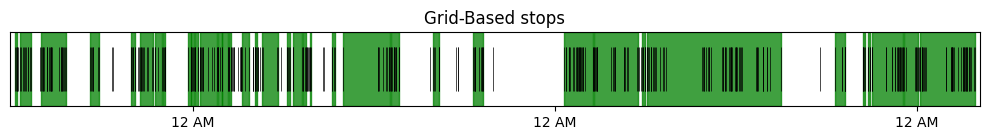

In [21]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_gb, ax=ax_barcode, stop_color='green', set_xlim=False, timestamp='unix_ts')
plt.title("Grid-Based stops")
plt.tight_layout()
plt.show()